[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![在 LangChain Academy 中打开](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)


# 研究助理

## 回顾

我们已经学习了几个关键的 LangGraph 主题：

* 记忆（Memory）
* 人类在环（Human-in-the-loop）
* 可控性（Controllability）

现在，我们把这些理念结合起来，解决一个最常见的 AI 应用：研究自动化。

研究往往是需要分析师投入大量时间的繁琐工作，AI 在这方面大有可为。

然而，研究过程需要高度定制；原始的 LLM 输出通常不适合真实的决策流程。

定制化、基于 AI 的[研究与报告生成](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag)工作流是一个很有前景的方向。

## 目标

我们的目标是在聊天模型之上构建一个轻量的多智能体系统，对研究流程进行定制化。

`选择数据源`
* 用户可以为调研选择任意输入来源。
  
`规划`
* 用户提供一个主题，系统会生成一支 AI 分析师团队，每位分析师专注于一个子主题。
* 在研究开始前，我们会通过 “人类在环” 来打磨这些子主题。
  
`LLM 使用方式`
* 每位分析师会使用选定的数据源，与专家级 AI 进行深入访谈。
* 访谈采用多轮对话，以提炼详实洞见，类似 [STORM](https://arxiv.org/abs/2402.14207) 论文中的做法。
* 这些访谈会通过 `sub-graphs` 捕获，并维护各自的内部状态。
  
`研究流程`
* 专家会并行地收集信息，回答分析师的问题。
* 所有访谈也会通过 `map-reduce` 同步进行。

`输出格式`
* 每次访谈收集来的洞见都会被整合进最终报告。
* 报告的提示词是可定制的，以便灵活调整输出格式。

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)


In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## 设置


In [2]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("OPENAI_API_KEY")
_set_env("DASHSCOPE_API_KEY")

In [3]:
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4o", temperature=0)

from langchain_community.chat_models import ChatTongyi

llm = ChatTongyi(model="qwen-plus", temperature=0)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


我们将使用 [LangSmith](https://docs.smith.langchain.com/) 来[追踪](https://docs.smith.langchain.com/concepts/tracing)。


In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## 生成分析师：人类在环

创建分析师，并通过人类在环流程审阅他们。


In [5]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field


class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(description="Name of the analyst.")
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )


# 图状态
class GenerateAnalystsState(TypedDict):
    topic: str  # Research topic
    max_analysts: int  # Number of analysts
    human_analyst_feedback: str  # Human feedback
    analysts: List[Analyst]  # Analyst asking questions

In [7]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""


# Node functions
def create_analysts(state: GenerateAnalystsState):
    """Create analysts"""

    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts,
    )

    # Generate question
    analysts = structured_llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="Generate the set of analysts.")]
    )

    # Write the list of analysis to state
    return {"analysts": analysts.analysts}


# Node functions
def human_feedback(state: GenerateAnalystsState):
    """No-op node that should be interrupted on"""
    pass


# conditional function
def should_continue(state: GenerateAnalystsState):
    """Return the next node to execute"""

    # Check if human feedback
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise end
    return END


# Add nodes and edges
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback", should_continue, ["create_analysts", END]
)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# View
# display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [8]:
# Input
max_analysts = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(
    {
        "topic": topic,
        "max_analysts": max_analysts,
    },
    thread,
    stream_mode="values",
):
    # Review
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Elena Martinez
Affiliation: Stanford University, Department of Computer Science
Role: AI Systems Researcher
Description: Focuses on scalable and modular architectures for AI agents. Interested in how LangGraph enables robust, stateful multi-agent workflows with clear debugging and monitoring capabilities.
--------------------------------------------------
Name: Rajiv Patel
Affiliation: TechLead at NeuroFlow AI
Role: Applied Machine Learning Engineer
Description: Concerned with practical integration, latency, and maintainability of agent frameworks in production environments. Motivated by LangGraph's ability to streamline deployment and reduce technical debt.
--------------------------------------------------
Name: Prof. Naomi Chen
Affiliation: MIT Media Lab
Role: Ethical AI & Human-AI Interaction Scholar
Description: Examines the implications of complex agent systems on transparency, accountability, and user trust. Seeks to understand how LangGraph’s visualizable execution pa

In [9]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [10]:
# We now update the state as if we are the human_feedback node
graph.update_state(
    thread,
    {
        "human_analyst_feedback": "Add in someone from a startup to add an entrepreneur perspective"
    },
    as_node="human_feedback",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09c155-f454-6806-8002-a9b3e18fc99f'}}

In [11]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Elena Martinez
Affiliation: Stanford University, Department of Computer Science
Role: AI Systems Researcher
Description: Focuses on scalable and modular architectures for AI agents. Interested in how LangGraph enables robust, stateful multi-agent workflows with clear debugging and monitoring capabilities.
--------------------------------------------------
Name: Rajiv Patel
Affiliation: TechLead at NeuroFlow AI
Role: Applied Machine Learning Engineer
Description: Concerned with practical integration, latency, and maintainability of agent frameworks in production environments. Motivated by LangGraph's ability to streamline deployment and reduce technical debt.
--------------------------------------------------
Name: Prof. Naomi Chen
Affiliation: MIT Media Lab
Role: Ethical AI & Human-AI Interaction Scholar
Description: Examines the implications of complex agent systems on transparency, accountability, and user trust. Seeks to understand how LangGraph’s visualizable execution pa

In [12]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(
    thread, {"human_analyst_feedback": further_feedack}, as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09c156-9dcb-60ba-8004-0a87d76c3b5f'}}

In [13]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [14]:
final_state = graph.get_state(thread)
analysts = final_state.values.get("analysts")

In [15]:
final_state.next

()

In [16]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Jordan Lee
Affiliation: TechForward Ventures
Role: Startup Founder & AI Entrepreneur
Description: A forward-thinking entrepreneur focused on rapid prototyping and scalable AI solutions for early-stage startups. Believes in lean development and time-to-market advantages.
--------------------------------------------------
Name: Dr. Elena Martinez
Affiliation: Institute for Scalable Systems
Role: Senior Research Scientist
Description: A systems architect specializing in long-lived, stateful agent workflows. Concerned with reliability, observability, and modularity in complex agent applications.
--------------------------------------------------
Name: Raj Patel
Affiliation: CodeLogic Inc.
Role: Lead Software Engineer
Description: A pragmatic software engineering lead who evaluates frameworks based on developer experience, maintainability, and integration with existing CI/CD pipelines.
--------------------------------------------------


## 开始访谈

### 生成问题

分析师会向专家提出问题。


In [17]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState


class InterviewState(MessagesState):
    max_num_turns: int  # Number turns of conversation
    context: Annotated[list, operator.add]  # Source docs
    analyst: Analyst  # Analyst asking questions
    interview: str  # Interview transcript
    sections: list  # Final key we duplicate in outer state for Send() API


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [18]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""


def generate_question(state: InterviewState):
    """Node to generate a question"""

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + messages)

    # Write messages to state
    return {"messages": [question]}

### 生成答案：并行化

专家会并行地从多个来源收集信息来回答问题。

例如，可以使用：

* 指定网站，例如 [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* 已建立索引的文档，例如 [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* 网络搜索
* Wikipedia 搜索

你可以尝试不同的网络搜索工具，比如 [Tavily](https://tavily.com/)。


In [19]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")

In [20]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search = TavilySearchResults(max_results=3)

/var/folders/zr/zsgg61wn27zbcvccfss34hpw0000gq/T/ipykernel_79481/2412712971.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [21]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

现在，我们创建用于搜索 Web 和 Wikipedia 的节点。

还会创建一个节点来回答分析师的问题。

最后，再创建节点来保存完整访谈记录，并撰写访谈摘要（“section”）。


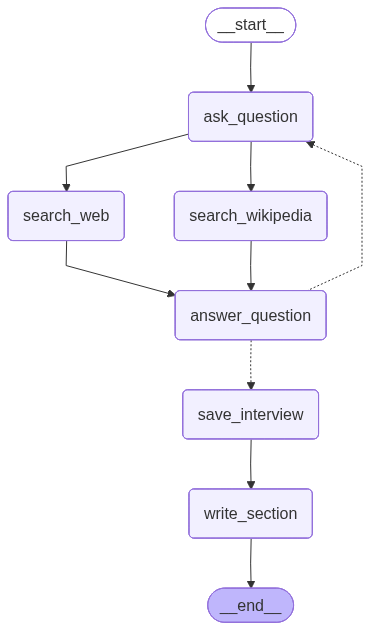

In [ ]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(
    content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query"""
)


# Node functions
# ask_question -> [search_web] -> answer_question
def search_web(state: InterviewState):
    """Retrieve docs from web search"""

    # Search query
    # 使用llm将之前的对话总结成一个query，用于搜索
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


# Node functions
# ask_question -> [search_wikipedia] -> answer_question
def search_wikipedia(state: InterviewState):
    """Retrieve docs from wikipedia"""

    # Search query
    # 使用llm将之前的对话总结成一个query，用于搜索wikipedia
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    # Search
    search_docs = WikipediaLoader(
        query=search_query.search_query, load_max_docs=2
    ).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""


# Node functions
# ask_question -> search_web/search_wikipedia -> [answer_question]
def generate_answer(state: InterviewState):
    """Node to answer a question"""

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}


# Node functions
# answer_question -> [save_interview] -> write_section
def save_interview(state: InterviewState):
    """Save interviews"""

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"interview": interview}


# Conditional function
# route_messages -> save_interview/ask_question
def route_messages(state: InterviewState, name: str = "expert"):
    """Route between question and answer"""

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "save_interview"

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return "save_interview"
    return "ask_question"


section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""


# Node functions
# save_interview -> [write_section] -> END
def write_section(state: InterviewState):
    """Node to answer a question"""

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"Use this source to write your section: {context}")]
    )

    # Append it to state
    return {"sections": [section.content]}


# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges(
    "answer_question", route_messages, ["ask_question", "save_interview"]
)
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(
    run_name="Conduct Interviews"
)

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [23]:
# Pick one analyst
analysts[0]

Analyst(affiliation='TechForward Ventures', name='Jordan Lee', role='Startup Founder & AI Entrepreneur', description='A forward-thinking entrepreneur focused on rapid prototyping and scalable AI solutions for early-stage startups. Believes in lean development and time-to-market advantages.')

这里我们运行访谈，传入与话题相关的 llama3.1 论文索引。


In [25]:
from IPython.display import Markdown

messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke(
    {"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread
)
Markdown(interview["sections"][0])

## Choosing LangGraph for Scalable, Stateful AI Workflows

For early-stage startups racing to build intelligent, adaptive AI agents, selecting the right framework can make or break time-to-market. While many tools promise rapid development, **LangGraph** stands out as a powerful choice for founders who need more than simple chatbots — they need robust, multi-step agents capable of dynamic decision-making, memory retention, and human oversight.

What makes LangGraph particularly compelling is its **graph-based architecture**, which models workflows as nodes (actions) and edges (transitions), enabling non-linear, conditional logic that evolves based on real-time outputs [1]. This flexibility is critical when building agents that must loop back, skip steps, or branch into different paths — such as research assistants, customer onboarding guides, or automated due diligence systems [2]. Unlike rigid chain-based workflows, LangGraph embraces the unpredictability of LLMs by ensuring the *framework itself* doesn’t introduce variability, making debugging and reliability far more manageable [3].

A key advantage for lean teams is **centralized state management**. LangGraph maintains a mutable `State` object that flows through every node, allowing all parts of the system to stay synchronized and consistent [4]. This eliminates the coordination overhead seen in decentralized models like AutoGen, where each agent manages its own memory and requires additional logic for synchronization [5]. Combined with **built-in persistence**, this enables long-running agents that remember past interactions and support human-in-the-loop interventions — essential for high-stakes domains like finance or healthcare [6].

Moreover, LangGraph’s deep integration with **LangSmith** provides unparalleled observability: execution tracing, time-travel debugging, and live inspection of state changes empower small teams to rapidly prototype, test, and refine complex agents without sacrificing control [7]. Real-world adoption by companies like Harmonic — who used LangGraph to streamline VC investment workflows — demonstrates its viability for collaborative, production-grade AI systems built quickly and safely [8].

### Sources  
[1] https://www.truefoundry.com/blog/autogen-vs-langgraph  
[2] https://latenode.com/blog/langgraph-vs-autogen-vs-crewai-complete-ai-agent-framework-comparison-architecture-analysis-2025  
[3] https://blog.langchain.com/building-langgraph/  
[4] https://blog.promptlayer.com/langgraph-vs-autogen/  
[5] https://composio.dev/blog/openai-agents-sdk-vs-langgraph-vs-autogen-vs-crewai  
[6] https://research.contrary.com/company/langchain  
[7] https://www.openxcell.com/blog/autogen-vs-langgraph/  
[8] https://blog.langchain.com/customers-harmonic/

### 并行访谈：Map-Reduce

我们通过 `Send()` API 将访谈并行化，作为 map 步骤。

然后在 reduce 步骤中将它们合并成报告主体。

### 完成

我们再添加最后一步，为最终报告写一段引言和结论。


In [27]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict


class ResearchGraphState(TypedDict):
    topic: str  # Research topic
    max_analysts: int  # Number of analysts
    human_analyst_feedback: str  # Human feedback
    analysts: List[Analyst]  # Analyst asking questions
    sections: Annotated[list, operator.add]  # Send() API key
    introduction: str  # Introduction for the final report
    content: str  # Content for the final report
    conclusion: str  # Conclusion for the final report
    final_report: str  # Final report

/var/folders/zr/zsgg61wn27zbcvccfss34hpw0000gq/T/ipykernel_79481/4122071232.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


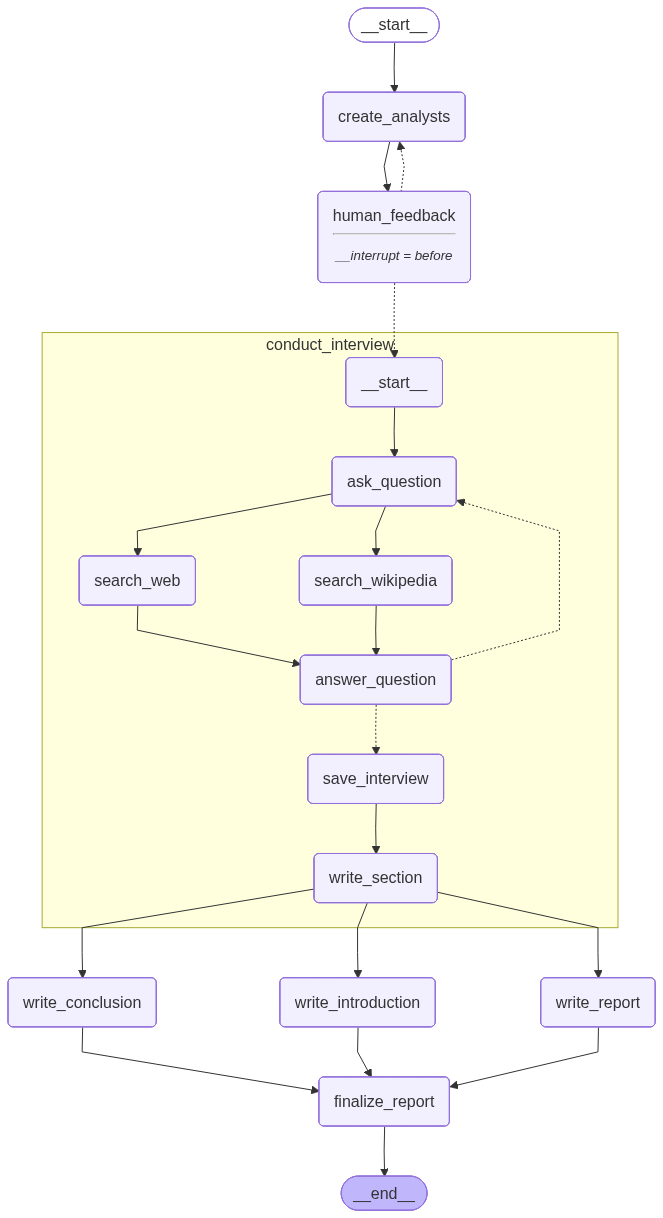

In [ ]:
from langgraph.constants import Send


def initiate_all_interviews(state: ResearchGraphState):
    """This is the "map" step where we run each interview sub-graph using Send API"""

    # Check if human feedback
    human_analyst_feedback = state.get("human_analyst_feedback")
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        ######################### map #########################
        return [
            Send(
                "conduct_interview",
                {
                    "analyst": analyst,
                    "messages": [
                        HumanMessage(
                            content=f"So you said you were writing an article on {topic}?"
                        )
                    ],
                },
            )
            for analyst in state["analysts"]
        ]
        ######################### map #########################


report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""


# Node functions
# conduct_interview.write_section -> [write_report]/write_introduction/write_conclusion -> finalize_report
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(
        topic=topic, context=formatted_str_sections
    )
    report = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"Write a report based upon these memos.")]
    )
    return {"content": report.content}


intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


# Node functions
# conduct_interview.write_section -> write_report/[write_introduction]/write_conclusion -> finalize_report
def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    ############## 与write_conclusion类似，区别： ###############
    intro = llm.invoke(
        [instructions] + [HumanMessage(content=f"Write the report introduction")]
    )
    ############## 与write_conclusion类似，区别： ###############
    return {"introduction": intro.content}


# Node functions
# conduct_interview.write_section -> write_report/write_introduction/[write_conclusion] -> finalize_report
def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    ############## 与write_introduction类似，区别： ###############
    conclusion = llm.invoke(
        [instructions] + [HumanMessage(content=f"Write the report conclusion")]
    )
    ############## 与write_introduction类似，区别： ###############
    return {"conclusion": conclusion.content}


# Node functions
# write_report/write_introduction/write_conclusion -> finalize_report
####################### reduce #######################
def finalize_report(state: ResearchGraphState):
    """The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion"""
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = (
        state["introduction"]
        + "\n\n---\n\n"
        + content
        + "\n\n---\n\n"
        + state["conclusion"]
    )
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}


####################### reduce #######################


# Add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"]
)
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(
    ["write_conclusion", "write_report", "write_introduction"], "finalize_report"
)
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

我们来问一个关于 LangGraph 的开放性问题。


In [29]:
# Inputs
max_analysts = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(
    {"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"
):

    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Elena Martinez
Affiliation: Institute for Advanced AI Studies
Role: AI Research Scientist
Description: Focuses on the architectural efficiency and scalability of agent frameworks. Interested in how LangGraph enables complex, stateful interactions compared to traditional models.
--------------------------------------------------
Name: Jordan Lee
Affiliation: TechNova Solutions
Role: Software Engineering Lead
Description: Concerned with practical integration, developer experience, and maintainability of agent systems in production environments. Evaluates LangGraph's impact on development velocity and system reliability.
--------------------------------------------------
Name: Priya Nair
Affiliation: FutureEdge Ventures
Role: Product Strategist
Description: Analyzes market readiness, competitive advantage, and long-term viability of adopting emerging agent frameworks like LangGraph for enterprise AI products.
--------------------------------------------------


In [30]:
# We now update the state as if we are the human_feedback node
graph.update_state(
    thread,
    {"human_analyst_feedback": "Add in the CEO of gen ai native startup"},
    as_node="human_feedback",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09c1b5-e5c9-69c0-8002-59ba8f2b638f'}}

In [31]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Elena Martinez
Affiliation: Institute for Advanced AI Studies
Role: AI Research Scientist
Description: Focuses on the architectural efficiency and scalability of agent frameworks. Interested in how LangGraph enables complex, stateful interactions compared to traditional models.
--------------------------------------------------
Name: Jordan Lee
Affiliation: TechNova Solutions
Role: Software Engineering Lead
Description: Concerned with practical integration, developer experience, and maintainability of agent systems in production environments. Evaluates LangGraph's impact on development velocity and system reliability.
--------------------------------------------------
Name: Priya Nair
Affiliation: FutureEdge Ventures
Role: Product Strategist
Description: Analyzes market readiness, competitive advantage, and long-term viability of adopting emerging agent frameworks like LangGraph for enterprise AI products.
--------------------------------------------------
Name: Dr. Elena Mar

In [32]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09c1b7-17fc-6040-8004-7559f0bb7b15'}}

In [33]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [34]:
from IPython.display import Markdown

final_state = graph.get_state(thread)
report = final_state.values.get("final_report")
Markdown(report)

# LangGraph: The Future of Human-Centered, Production-Ready AI Agents

## Introduction

As AI agents transition from simple automation tools to collaborative partners in complex workflows, the demand for frameworks that balance intelligence with transparency and scalability has intensified. LangGraph rises to this challenge by reimagining agent architecture through stateful, graph-based workflows that support dynamic decision-making, persistent memory, and multi-agent coordination. Unlike linear chains, LangGraph enables cyclical, adaptable processes essential for real-world applications—from customer service to healthcare—while natively integrating human-in-the-loop oversight to ensure trust and control. With built-in checkpointing, enterprise-grade persistence, and seamless LLM integrations, it provides the reliability needed for production deployment. This report explores how LangGraph is setting a new standard for agentic systems, merging architectural innovation with human-centered design to power the next generation of AI collaboration.

---



LangGraph is redefining the landscape of AI agent development by offering a robust, graph-based framework that prioritizes statefulness, collaboration, and production readiness. Unlike traditional linear chains such as LangChain, LangGraph enables dynamic, cyclical workflows where execution paths can branch, loop, and adapt based on real-time conditions—making it ideal for complex applications requiring iterative reasoning, resilience, and multi-agent coordination [1]. This architectural shift from rigid sequences to flexible state machines allows developers to model sophisticated behaviors like long-running conversations, self-correction through feedback loops, and fault-tolerant task execution, all of which are essential for deploying reliable AI systems in real-world environments [2].

A core strength of LangGraph lies in its explicit state management, which gives developers granular control over data persistence and transformation across nodes. This capability supports advanced patterns such as shared memory in multi-agent systems, contextual continuity in customer interactions, and auditable decision trails—critical for high-stakes domains like healthcare, finance, and customer service [3]. The framework’s message-passing architecture, inspired by Google’s Pregel model, facilitates seamless communication between agents via channels and structured state transitions, enabling cooperative problem-solving and distributed cognition [4].

Crucially, LangGraph is designed with human-centered collaboration in mind. Its native support for human-in-the-loop (HITL) workflows allows processes to pause for review or approval, ensuring oversight without sacrificing automation efficiency [5]. Combined with streaming outputs that provide real-time visibility into agent progress, this fosters trust, reduces cognitive load, and mirrors natural team dynamics where humans and AI co-operate rather than operate in isolation [6]. These features make LangGraph particularly well-suited for applications requiring transparency, interpretability, and user empowerment.

For production-grade deployments, LangGraph offers built-in checkpointing that serializes execution state at each step, allowing workflows to resume after interruptions—a necessity for enterprise-scale, long-running agents [7]. Supported by backends like SQLite, PostgreSQL, and optimized solutions such as KurrentDB, this persistence layer ensures scalability and concurrency control in high-throughput environments [4]. Integration with major LLM platforms including Amazon Bedrock and Mistral further enhances its cloud-native applicability, while workflow visualization tools improve developer maintainability and debugging efficiency [7].

LangGraph also aligns with emerging paradigms like Agent2Agent (A2A), enabling local simulation of interoperable multi-agent ecosystems and preparing developers for future decentralized AI networks [8]. When combined with LLMOps platforms such as ZenML for versioning, pipeline orchestration, and deployment automation, LangGraph forms part of a comprehensive stack that bridges the gap between prototyping and industrial-scale deployment [1]. As organizations move beyond experimental AI toward dependable, observable, and scalable agent systems, LangGraph is emerging as the foundational framework powering the next generation of intelligent, collaborative, and production-ready agentic architectures [9].

## Sources  
[1] https://www.zenml.io/blog/agno-vs-langgraph  
[2] https://medium.com/@hayagriva99999/langgraph-powering-the-next-generation-of-ai-agents-part-1-8c8cfde98cb5  
[3] https://edzor.com/blogs/langgraph-ai-applications-beginners/  
[4] https://www.kurrent.io/blog/langgraph-checkpointer-on-kurrentdb/  
[5] https://medium.com/@onurpolat711/langgraph-a2a-simulating-multi-agent-ai-collaboration-for-developers-ca4a26f9bbe3  
[6] https://www.cohorte.co/blog/unleashing-the-power-of-langgraph-an-introduction-to-the-future-of-ai-workflows  
[7] https://aws.amazon.com/blogs/machine-learning/build-a-multi-agent-system-with-langgraph-and-mistral-on-aws/  
[8] https://rapidinnovation.io/post/ai-agents-in-langgraph  
[9] https://medium.com/@vikaskumarsingh_60821/langgraph-the-future-of-production-grade-ai-agent-architectures-623d68dbbfb6

---

## Conclusion

LangGraph stands at the forefront of a transformative shift in AI agent design—moving from rigid, linear workflows to dynamic, stateful, and collaborative systems built for real-world complexity. By enabling cyclical control flows, explicit state management, and resilient checkpointing, it provides the architectural foundation for production-grade agents that can adapt, persist, and recover. Its native support for human-in-the-loop oversight ensures transparency and trust, while its multi-agent capabilities align with emerging A2A standards, paving the way for scalable, interoperable AI ecosystems. Integrated with leading LLM platforms and LLMOps tooling, LangGraph not only powers intelligent workflows but also delivers the observability, maintainability, and reliability essential for enterprise deployment. As organizations advance beyond prototypes, LangGraph emerges as the critical backbone of next-generation agentic systems—where AI doesn’t just act, but collaborates intelligently with humans and other agents over time.

我们可以查看这次运行的追踪：

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r
